In [1]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())

%load_ext autoreload
%autoreload 2

/Users/miguel/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


OS:  darwin
Python:  3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 18:11:28) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow:  1.5.0
Numpy:  1.14.1
Number of CPU processors:  8


### Data

In [2]:
DATA = os.path.join('data', 'MSFT_2012_2017.csv')
EPOCHS = 5
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 1
UNITS = 25

In [3]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


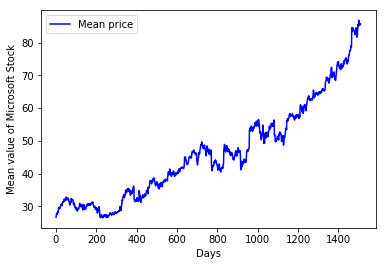

In [4]:
mean_price = df.mean(axis = 1)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

In [6]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [7]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1054, 1, 1) (1054,)
(451, 1, 1) (451,)


### LSTM

In [8]:
def create_symbol(X, model_name='LSTM', units=10, activation='linear', time_ahead=1):
    if model_name == 'LSTM':
        cell = tf.contrib.rnn.LSTMCell(units)
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    elif model_name == 'BiLSTM':
        lstm_fw_cell = rnn.BasicLSTMCell(units, forget_bias=1.0)
        lstm_bw_cell = rnn.BasicLSTMCell(units, forget_bias=1.0)
        outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, X,
                                              dtype=tf.float32)
    elif model_name == 'GRU':
        cell = tf.contrib.rnn.GRUCell(units)
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    else:
        raise ValueError("Wrong model name")
    sym = tf.layers.dense(outputs[-1], 1, activation=None, name='output')#activation=None (linear activation)
    return sym

In [9]:
# Place-holders
X = tf.placeholder(tf.float32, shape=[None, 1, TIME_AHEAD])
y = tf.placeholder(tf.float32, shape=[None])

sym = create_symbol(X, model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD)

loss = tf.reduce_mean(tf.squared_difference(sym, y)) #mse
optimizer = tf.train.AdamOptimizer()
model = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
for i in range(EPOCHS):
    ii = 0
    while(ii + BATCH_SIZE) <= len(X_train):
        X_batch = X_train[ii:ii+BATCH_SIZE,:,:]
        y_batch = y_train[ii:ii+BATCH_SIZE]
        sess.run(model, feed_dict={X:X_batch, y:y_batch})
        ii += BATCH_SIZE
    loss_train = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
    print('Epoch {}/{}'.format(i+1, EPOCHS), ' Current loss: {}'.format(loss_train))

Epoch 1/5  Current loss: 7.991367601789534e-05
Epoch 2/5  Current loss: 4.7972367610782385e-05
Epoch 3/5  Current loss: 2.9974151402711868e-05
Epoch 4/5  Current loss: 1.1699426067934837e-05
Epoch 5/5  Current loss: 2.9472744245140348e-06


In [12]:
y_guess = np.zeros(y_test.shape[0], dtype=np.float32)
ii = 0
while(ii + BATCH_SIZE) <= len(X_test):
    X_batch = X_test[ii:ii+BATCH_SIZE,:,:]
    output = sess.run(sym, feed_dict={X:X_batch})
    y_guess[ii:ii+BATCH_SIZE] = output
    ii += BATCH_SIZE

In [30]:
y_test_inv = scaler.inverse_transform([y_test])
pred_test = scaler.inverse_transform([y_guess])
score = math.sqrt(mean_squared_error(y_test_inv, pred_test))
print('Test RMSE: %.2f' % (score))

Test RMSE: 3.30


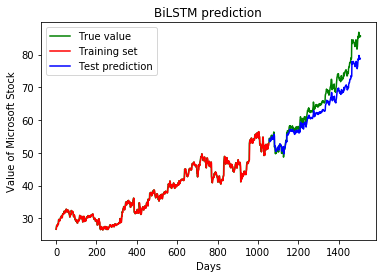

In [31]:
mean_price_inv = scaler.inverse_transform(mean_price)
train_set = mean_price_inv[:X_train.shape[0]]
plot_series_prediction(mean_price_inv, train_set, pred_test.T, time_ahead=TIME_AHEAD,
                       title='BiLSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       color=['g','r','b'], legend=['True value','Training set','Test prediction'])